In [13]:
import gluonts
gluonts.__version__

'0.4.2'

In [14]:
import mxnet
mxnet.__version__

'1.4.1'

In [15]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [16]:
dataname = "m4_daily"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily.


In [17]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [18]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [19]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json'), line=1), row=1)}

## Plot Series

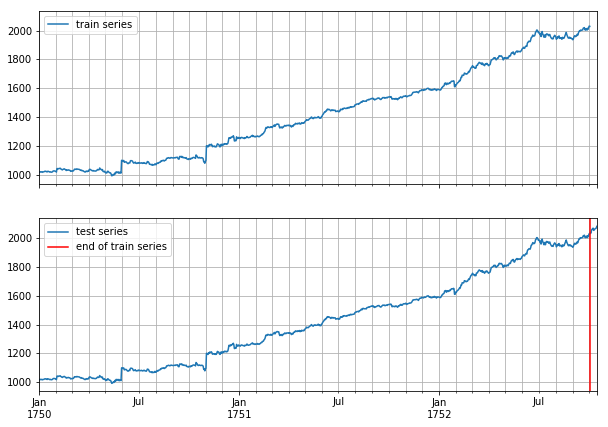

In [20]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [21]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [22]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly_macro", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 531963
100%|██████████| 100/100 [00:03<00:00, 28.10it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[0] Elapsed time 3.561 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.421212
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.83it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.470 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.627236
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.97it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[2] Elapsed time 3.579 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.228524
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.41it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 3.290 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.003125
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.38it/s, avg_epoch_loss=7.

100%|██████████| 100/100 [00:06<00:00, 16.65it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[37] Elapsed time 6.013 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.793202
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.86it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 6.318 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.786496
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.37it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[39] Elapsed time 5.766 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.818625
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.39it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[40] Elapsed time 5.443 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.614666
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 16.94it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[41] Elapsed time 5.911 second